In [1]:
from data_model import WineData, WHITE_WINE_PATH, RED_WINE_PATH
from network import run
from torch.utils.data import Dataset, DataLoader


# Explaining pytorch model of wine quality dataset using Shap

## Train class_weights 
Firstly let's run the training loop and save the resulting 

*NOTE*: The model has 7 classes so accuracy is calculated here for a multiclass problem where a random
guess gives us a 1/7 (0.14) random probability of being correct, not taking class distribution into account.  

In [2]:
model = run()

Epoch[50] Loss:[0.69]
EVALUATOR: Training Results - Epoch: 50  Avg accuracy: 0.51  Avg loss: 0.8062
Epoch[100] Loss:[0.86]
EVALUATOR: Training Results - Epoch: 100  Avg accuracy: 0.51  Avg loss: 0.7985
Epoch[150] Loss:[0.77]
EVALUATOR: Training Results - Epoch: 150  Avg accuracy: 0.51  Avg loss: 0.7935
Epoch[200] Loss:[1.02]
EVALUATOR: Training Results - Epoch: 200  Avg accuracy: 0.52  Avg loss: 0.7920
Epoch[250] Loss:[0.72]
EVALUATOR: Training Results - Epoch: 250  Avg accuracy: 0.51  Avg loss: 0.7905
Epoch[300] Loss:[0.79]
EVALUATOR: Training Results - Epoch: 300  Avg accuracy: 0.52  Avg loss: 0.7885
Epoch[350] Loss:[0.73]
EVALUATOR: Training Results - Epoch: 350  Avg accuracy: 0.52  Avg loss: 0.7882
Epoch[400] Loss:[0.71]
EVALUATOR: Training Results - Epoch: 400  Avg accuracy: 0.52  Avg loss: 0.7877
Epoch[450] Loss:[0.81]
EVALUATOR: Training Results - Epoch: 450  Avg accuracy: 0.52  Avg loss: 0.7872
Epoch[500] Loss:[0.74]
EVALUATOR: Training Results - Epoch: 500  Avg accuracy: 0.52 

## Get Wine Data
Using the dataset and dataloader specified in data_model.py we import a train and test data set
and create a dataloader for each

In [3]:
data = WineData.read_data(WHITE_WINE_PATH)

train_data, test_data = WineData.train_test_splitter(data)

wd = WineData(train_data)
wd_test = WineData(test_data)


## Create DeepExplainer
Using our model we create a new instance of the `shap.DeepExplainer()` using the train data's x values as background inputs.

Shap will provide us with an *approximation* of the model's behaviour **not** the underlying data itself. 
That is to say shap approximates the model, which we hope represents our data well. However if our model is a bad fit
shap will give us an approxmiation of a bad model. 

 *garbage in, garbage out*. 

In [4]:
import shap

In [29]:
# explainer will use the first 1000 instances in x_data
e = shap.DeepExplainer(model, wd.x_data[:1000] )

In [30]:
wd.x_data.shape

torch.Size([4408, 11])

In [46]:
quality = [i+3 for i in range(7)]

In [48]:
quality

[3, 4, 5, 6, 7, 8, 9]

In [61]:
for q, w in zip(quality, wd.class_weights.data):
    print(q,"hello")

3 hello
4 hello
5 hello
6 hello
7 hello
8 hello
9 hello


In [31]:
# shap values can take a really long time to calculate
# let's limit the shap values to the first 1000 rows in `wd.x_data`
shap_values = e.shap_values(wd.x_data[:1000])

In [32]:
FEATURE_NAMES =["fixed acidity","volatile acidity","citric acid","residual sugar","chlorides","free sulfur dioxide","total sulfur dioxide","density","pH","sulphates","alcohol"
]

In [33]:
shap.initjs()

# Summarizing The Model For All Classes

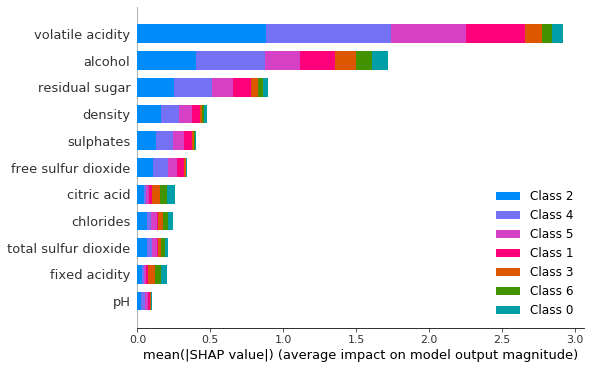

In [34]:
shap.summary_plot(shap_values, wd.x_data[:100],feature_names=FEATURE_NAMES)

# Model Summary For Class 0 (e.g. worst quality)

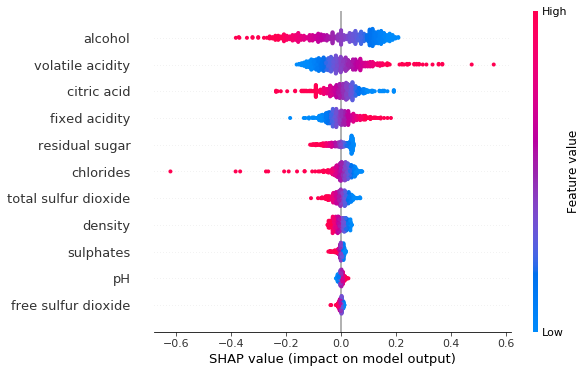

In [35]:
shap.summary_plot(shap_values[0][0:500], wd.x_data[:500], feature_names=FEATURE_NAMES)

# Model Summary For Class 1 

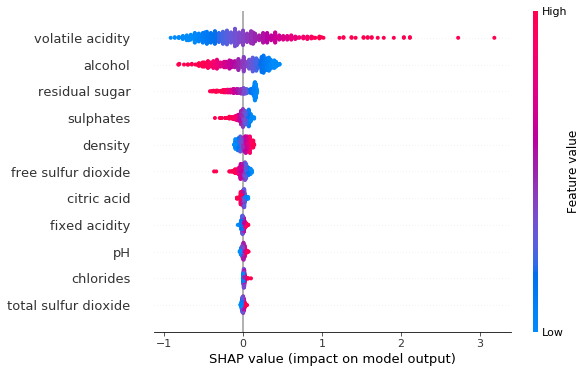

In [36]:
shap.summary_plot(shap_values[1][0:500], wd.x_data[:500], feature_names=FEATURE_NAMES)

# Model Summary For Class 2

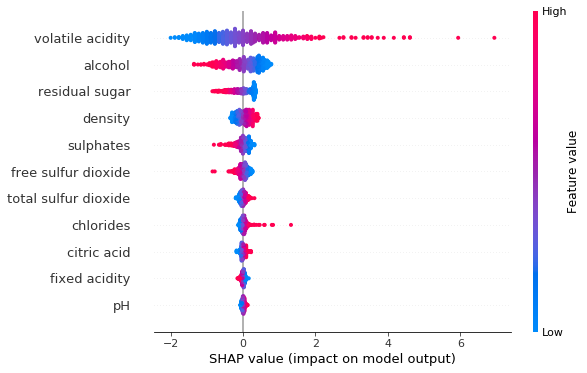

In [37]:
shap.summary_plot(shap_values[2][0:500], wd.x_data[:500], feature_names=FEATURE_NAMES)

# Model Summary For Class 3 

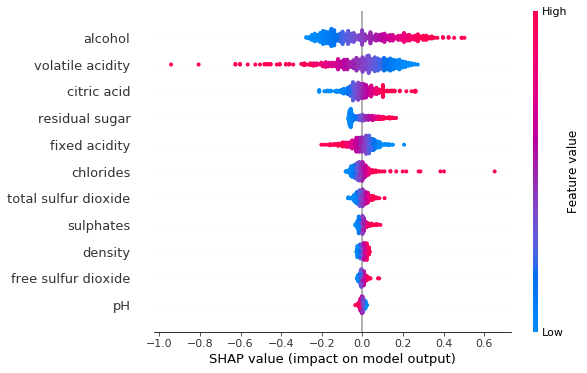

In [38]:
shap.summary_plot(shap_values[3][0:500], wd.x_data[:500], feature_names=FEATURE_NAMES)

# Model Summary For Class 4 

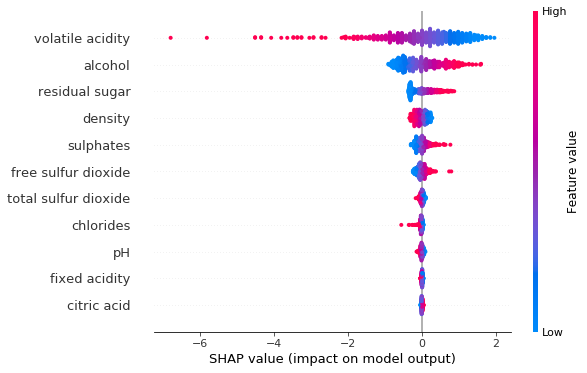

In [39]:
shap.summary_plot(shap_values[4][0:500], wd.x_data[:500], feature_names=FEATURE_NAMES)

# Model Summary For Class 5 

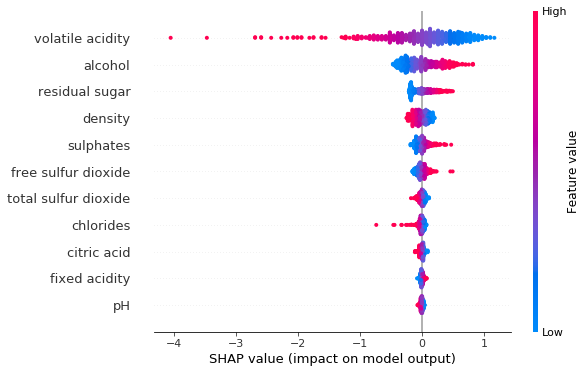

In [40]:
shap.summary_plot(shap_values[5][0:500], wd.x_data[:500], feature_names=FEATURE_NAMES)

# Model Summary For Class 6 

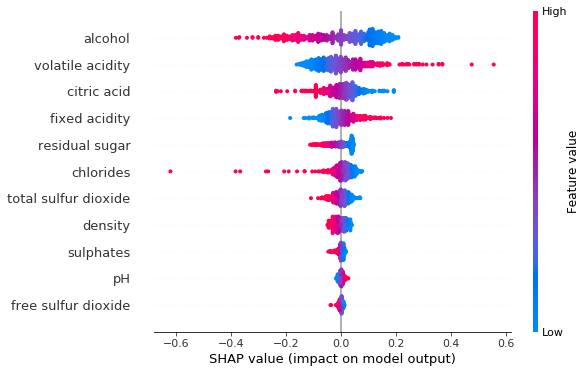

In [41]:
shap.summary_plot(shap_values[0][0:500], wd.x_data[:500], feature_names=FEATURE_NAMES)

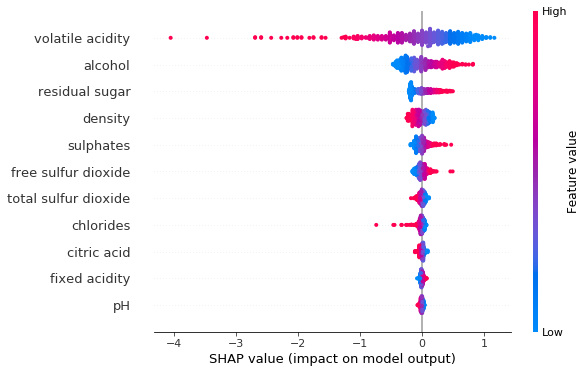

In [44]:
shap.summary_plot(shap_values[5][0:500], wd.x_data[:500], feature_names=FEATURE_NAMES)